In [1]:
# Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


In [2]:
# Load dataset and labels for anomaly detection
data = pd.read_csv("data/dataset.csv") 
labels = pd.read_csv("data/label.csv")['Label'] # to be used for evalutaion purposes

#print(list(labels).count(1))
#print(list(labels).count(0))


In [3]:
# Split data into train/test sets with a 70/30 split 
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

# Normalizing the data
scaler = Normalizer()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

# Convert to tensors
x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)

In [4]:
class Autoencoder(nn.Module):
    '''
    Autoencoder Model
    '''
    def __init__(self, input_dim, encoding_dim, dropout) -> None:
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),     
            nn.ReLU(),                              
            nn.Dropout(dropout),
            nn.Linear(input_dim // 2, encoding_dim),     
            nn.ReLU(),  
            nn.Dropout(dropout)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim // 2, ),    
            nn.ReLU(),  
            nn.Dropout(dropout),
            nn.Linear(input_dim //2, input_dim),  
            nn.ReLU(),
        )
    
    def forward(self,x):
        encoded = self.encoder(x)
        decorded = self.decoder(encoded)
        return decorded


In [5]:
# Hyperparameters                               
INPUT_DIM = x_train_tensor.shape[1]
ENCODING_DIM = 5
DROPOUT = 0.01
EPOCHS = 7
BATCH_SIZE = 32
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0003

model = Autoencoder(input_dim=INPUT_DIM,encoding_dim=ENCODING_DIM, dropout=DROPOUT)
print(model)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay = WEIGHT_DECAY)  
loss_function = nn.MSELoss()

train_dataloader = DataLoader(x_train_tensor, batch_size=BATCH_SIZE, shuffle=True)

# Initializing lists for average MSE on each epoch
train_losses = [] 
test_losses = []

# Initializing lists for reconstucted matrix on each epoch
reconstructed_train = []
reconstructed_test = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = []
    print(f"[TRAINING]: Starting epoch {epoch}...")
    for batch in train_dataloader:
        optimizer.zero_grad()
        reconstructed = model(batch)
        reconstructed_train.append(reconstructed)
        loss = loss_function(reconstructed, batch)
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
    
    loss_train = torch.tensor(epoch_loss).mean().item()
    train_losses.append(loss_train)

    # Evaluating model on test set
    model.eval()
    with torch.no_grad():
        test_output = model(x_test_tensor)
        reconstruction_error = np.mean(np.power(x_test_scaled - test_output.detach().numpy(), 2), axis=1)

        loss_test = loss_function(test_output, x_test_tensor)
        test_losses.append(loss_test)
    
    print(f"Epoch {epoch + 1}/{EPOCHS}, Training Loss: {loss_train} Test Loss: {loss_test}")



Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=89, out_features=44, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=44, out_features=5, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.01, inplace=False)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=44, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=44, out_features=89, bias=True)
    (4): ReLU()
  )
)
[TRAINING]: Starting epoch 0...
Epoch 1/7, Training Loss: 0.010447918437421322 Test Loss: 0.006687417160719633
[TRAINING]: Starting epoch 1...
Epoch 2/7, Training Loss: 0.004964227322489023 Test Loss: 0.0030193706043064594
[TRAINING]: Starting epoch 2...
Epoch 3/7, Training Loss: 0.0021273791790008545 Test Loss: 0.001534845563583076
[TRAINING]: Starting epoch 3...
Epoch 4/7, Training Loss: 0.001673203194513917 Test Loss: 0.0014906579162925482
[TRAINING]: Starting epoch 4...
Epoch 5/7, Training Loss: 

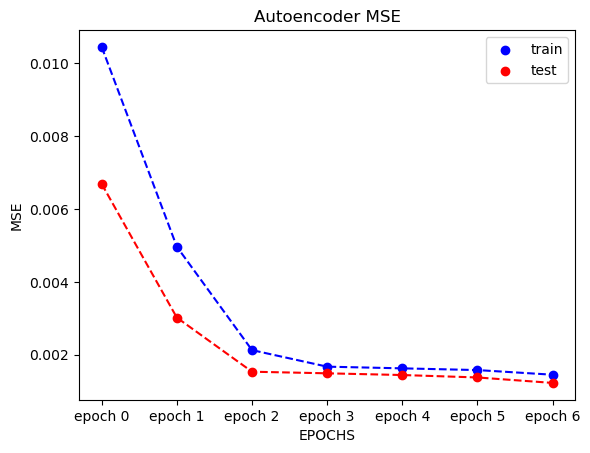

In [6]:
# Plotting average train and test MSE for each epoch
epochs = [0,1,2,3,4,5,6]
plt.scatter(epochs, train_losses, color='blue')
plt.scatter(epochs, test_losses, color="red")
plt.legend(['train', 'test'])
plt.plot(epochs, train_losses, 'b--')
plt.plot(epochs, test_losses, 'r--')
plt.title('Autoencoder MSE')
plt.xlabel('EPOCHS')
plt.xticks(epochs, ['epoch 0', 'epoch 1','epoch 2', 'epoch 3', 'epoch 4', 'epoch 5', 'epoch 6'])
plt.ylabel('MSE')
plt.show()

In [7]:
# Autoencoder in eval mode, results to be used to calculate reconstruction error
model.eval()
with torch.no_grad():
    reconstructed_train = model(x_train_tensor).detach().numpy()
    reconstructed_test = model(x_test_tensor).detach().numpy()

# Reconstruction errors
train_error = np.mean((x_train_tensor.detach().numpy() - reconstructed_train) ** 2, axis=1)
test_error = np.mean((x_test_tensor.detach().numpy() - reconstructed_test) ** 2, axis=1)


In [8]:
# K-Means Clustering on training and test sets
kmeans = KMeans(n_clusters=2, n_init='auto') #cluster for normal traffic and cluster for not normal 
errors = np.concatenate([train_error, test_error])
true_labels = np.concatenate([y_train, y_test])

predictions = kmeans.fit_predict(errors.reshape(-1,1))

clusters = [errors[predictions == 1].mean(), errors[predictions == 0].mean()]
anomolous = np.argmax(clusters) # bigger error means anomalies

# Label predicitions based on what is considered to be anomalous (1) and normal (0)
predicted_labels = np.where(predictions == anomolous, 1, 0)

# Classification report
cr = classification_report(true_labels, predicted_labels)
print('Classification Report:')
print(cr)


# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print('Confusion Matrix')
print(conf_matrix)




Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.36      0.52      2396
           1       0.27      0.94      0.42       604

    accuracy                           0.47      3000
   macro avg       0.61      0.65      0.47      3000
weighted avg       0.82      0.47      0.50      3000

Confusion Matrix
[[ 852 1544]
 [  38  566]]


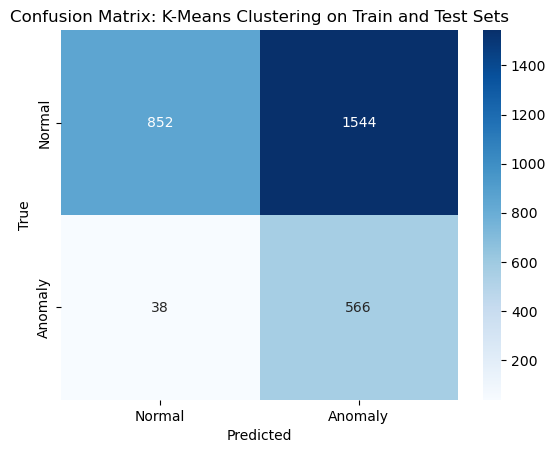

In [9]:
# Plotting confusion matrix for train and test sets
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: K-Means Clustering on Train and Test Sets")
plt.show()

In [10]:
# K-Means Clustering on only the test set
kmeans = KMeans(n_clusters=2, n_init='auto') #cluster for normal traffic and cluster for not normal 

predictions = kmeans.fit_predict(test_error.reshape(-1,1))
clusters = [test_error[predictions == 1].mean(), test_error[predictions == 0].mean()]
anomolous = np.argmax(clusters) # bigger error means anomalies

# Label predicitions based on what is considered to be anomalous (1) and normal (0)
predicted_labels = np.where(predictions == anomolous, 1, 0)


# Classification report
cr = classification_report(y_test, predicted_labels)
print('Classification Report:')
print(cr)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)
print('Confusion Matrix')
print(conf_matrix)


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.37      0.53       715
           1       0.28      0.94      0.43       185

    accuracy                           0.48       900
   macro avg       0.62      0.65      0.48       900
weighted avg       0.82      0.48      0.51       900

Confusion Matrix
[[262 453]
 [ 12 173]]


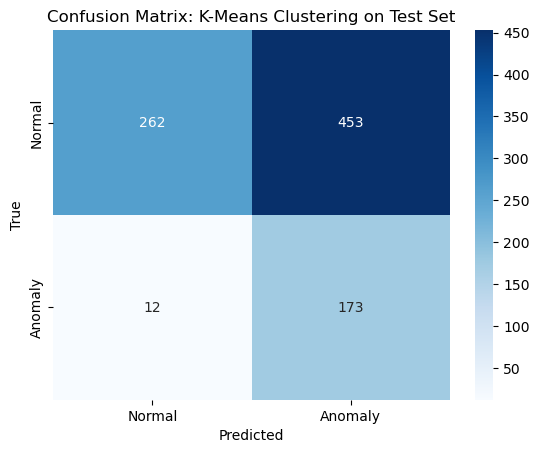

In [11]:
# Plotting confusion matrix for test set
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: K-Means Clustering on Test Set")
plt.show()